
# RBF SVM parameters

This example illustrates the effect of the parameters ``gamma`` and ``C`` of
the Radial Basis Function (RBF) kernel SVM.

Intuitively, the ``gamma`` parameter defines how far the influence of a single
training example reaches, with low values meaning 'far' and high values meaning
'close'. The ``gamma`` parameters can be seen as the inverse of the radius of
influence of samples selected by the model as support vectors.

The ``C`` parameter trades off correct classification of training examples
against maximization of the decision function's margin. For larger values of
``C``, a smaller margin will be accepted if the decision function is better at
classifying all training points correctly. A lower ``C`` will encourage a
larger margin, therefore a simpler decision function, at the cost of training
accuracy. In other words ``C`` behaves as a regularization parameter in the
SVM.

The first plot is a visualization of the decision function for a variety of
parameter values on a simplified classification problem involving only 2 input
features and 2 possible target classes (binary classification). Note that this
kind of plot is not possible to do for problems with more features or target
classes.

The second plot is a heatmap of the classifier's cross-validation accuracy as a
function of ``C`` and ``gamma``. For this example we explore a relatively large
grid for illustration purposes. In practice, a logarithmic grid from
$10^{-3}$ to $10^3$ is usually sufficient. If the best parameters
lie on the boundaries of the grid, it can be extended in that direction in a
subsequent search.

Note that the heat map plot has a special colorbar with a midpoint value close
to the score values of the best performing models so as to make it easy to tell
them apart in the blink of an eye.

The behavior of the model is very sensitive to the ``gamma`` parameter. If
``gamma`` is too large, the radius of the area of influence of the support
vectors only includes the support vector itself and no amount of
regularization with ``C`` will be able to prevent overfitting.

When ``gamma`` is very small, the model is too constrained and cannot capture
the complexity or "shape" of the data. The region of influence of any selected
support vector would include the whole training set. The resulting model will
behave similarly to a linear model with a set of hyperplanes that separate the
centers of high density of any pair of two classes.

For intermediate values, we can see on the second plot that good models can
be found on a diagonal of ``C`` and ``gamma``. Smooth models (lower ``gamma``
values) can be made more complex by increasing the importance of classifying
each point correctly (larger ``C`` values) hence the diagonal of good
performing models.

Finally, one can also observe that for some intermediate values of ``gamma`` we
get equally performing models when ``C`` becomes very large. This suggests that
the set of support vectors does not change anymore. The radius of the RBF
kernel alone acts as a good structural regularizer. Increasing ``C`` further
doesn't help, likely because there are no more training points in violation
(inside the margin or wrongly classified), or at least no better solution can
be found. Scores being equal, it may make sense to use the smaller ``C``
values, since very high ``C`` values typically increase fitting time.

On the other hand, lower ``C`` values generally lead to more support vectors,
which may increase prediction time. Therefore, lowering the value of ``C``
involves a trade-off between fitting time and prediction time.

We should also note that small differences in scores results from the random
splits of the cross-validation procedure. Those spurious variations can be
smoothed out by increasing the number of CV iterations ``n_splits`` at the
expense of compute time. Increasing the value number of ``C_range`` and
``gamma_range`` steps will increase the resolution of the hyper-parameter heat
map.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv("../data/DoE_Data_1_4.csv", index_col=0)
df = df.dropna()
df = df.set_index([pd.Index(np.array(range(97)))])
df.g_pres = df['Res: Graphene Presence']
df.g_pres.value_counts()

No       52
Yes      34
Maybe    11
Name: Res: Graphene Presence, dtype: int64

In [10]:
#df.iloc[:,2:14]

In [11]:
df_data_pos = df.iloc[:,2:14]
df_data_neg = df.iloc[:,2:14]

def f_pos(GP):
    if GP == 'Maybe' or GP == 'Yes':
        return 1
    elif GP =='No':
        return 0

def f_neg(GP):
    if GP == 'Maybe' or GP == 'No':
        return 0
    elif GP =='Yes':
        return 1
    
df_data_pos['Res: Graphene Presence'] = df_data_pos['Res: Graphene Presence'].apply(f_pos)
df_data_neg['Res: Graphene Presence'] = df_data_neg['Res: Graphene Presence'].apply(f_neg)

df_data_neg

,Annealing H2 (sccm),Growth H2 (sccm),Growth CH4 (sccm),Growth He (sccm),Cooling H2 (sccm),Cooling CH4 (sccm),Cooling He (sccm),Growth Time (min),Dew Point (C),Temperature (C),Relative Humidity (pct),Res: Graphene Presence
0,100.0,100.0,1.00000,100.00000,0,0.00000,100.00000,5.0,1.90,23.2,24.681526,0
1,100.0,100.0,1.00000,100.00000,0,0.00000,100.00000,5.0,1.74,23.0,24.697922,0
2,500.0,500.0,5.00000,500.00000,0,0.00000,500.00000,5.0,5.30,23.1,31.548652,1
3,100.0,100.0,1.00000,100.00000,0,0.00000,100.00000,5.0,-1.86,23.2,18.791646,0
4,500.0,500.0,5.00000,500.00000,0,0.00000,500.00000,15.0,-1.86,23.2,18.791646,1
...,...,...,...,...,...,...,...,...,...,...,...,...
92,50.0,25.0,0.01716,476.69884,25,0.01716,476.69884,7.5,0.26,21.7,24.030716,0
93,50.0,25.0,0.01716,476.69884,25,0.01716,476.69884,10.0,1.30,22.9,24.077087,0
94,50.0,50.0,0.03432,953.39768,50,0.03432,953.39768,5.0,1.10,22.0,25.068069,0
95,50.0,50.0,0.03432,953.39768,50,0.03432,953.39768,7.5,-4.82,22.0,16.209052,0


In [12]:
df_data_pos.iloc[:,:-1]

,Annealing H2 (sccm),Growth H2 (sccm),Growth CH4 (sccm),Growth He (sccm),Cooling H2 (sccm),Cooling CH4 (sccm),Cooling He (sccm),Growth Time (min),Dew Point (C),Temperature (C),Relative Humidity (pct)
0,100.0,100.0,1.00000,100.00000,0,0.00000,100.00000,5.0,1.90,23.2,24.681526
1,100.0,100.0,1.00000,100.00000,0,0.00000,100.00000,5.0,1.74,23.0,24.697922
2,500.0,500.0,5.00000,500.00000,0,0.00000,500.00000,5.0,5.30,23.1,31.548652
3,100.0,100.0,1.00000,100.00000,0,0.00000,100.00000,5.0,-1.86,23.2,18.791646
4,500.0,500.0,5.00000,500.00000,0,0.00000,500.00000,15.0,-1.86,23.2,18.791646
...,...,...,...,...,...,...,...,...,...,...,...
92,50.0,25.0,0.01716,476.69884,25,0.01716,476.69884,7.5,0.26,21.7,24.030716
93,50.0,25.0,0.01716,476.69884,25,0.01716,476.69884,10.0,1.30,22.9,24.077087
94,50.0,50.0,0.03432,953.39768,50,0.03432,953.39768,5.0,1.10,22.0,25.068069
95,50.0,50.0,0.03432,953.39768,50,0.03432,953.39768,7.5,-4.82,22.0,16.209052


The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.83


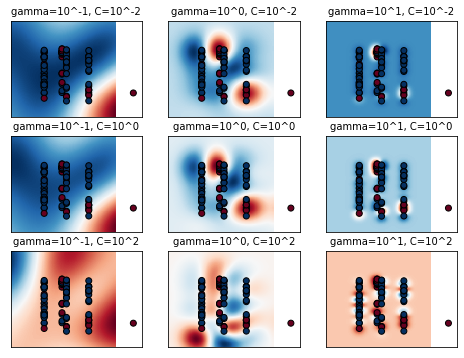

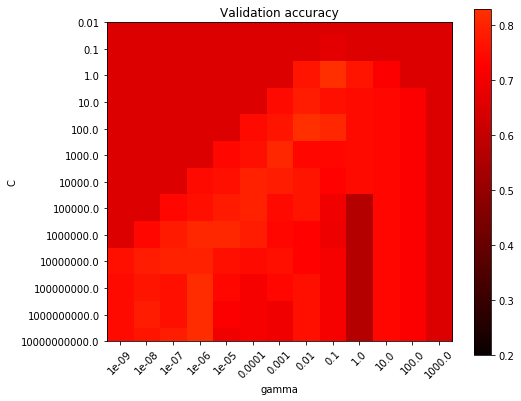

In [13]:
# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# #############################################################################
# Load and prepare data set
#
# dataset for grid search

### iris = load_iris()
### X = iris.data
### y = iris.target

X = df_data_neg.iloc[:,:-1].values
y = df_data_neg.iloc[:,-1].values

# Dataset for decision function visualization: we only keep the first two
# features in X and sub-sample the dataset to keep only 2 classes and
# make it a binary classification problem.

X_2d = X[:, 7:9]
#X_2d = X_2d[y > 0]
#y_2d = y[y > 0]
#y_2d -= 1
y_2d = y

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

# #############################################################################
# Train classifiers
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

# #############################################################################
# Visualization
#
# draw visualization of parameter effects

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

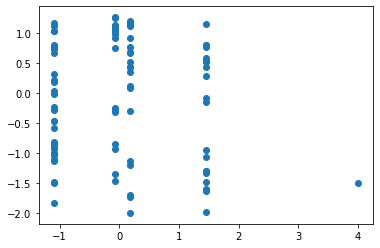

In [14]:
plt.scatter(X_2d[:, 0], X_2d[:, 1])

The best parameters are {'C': 10.0, 'gamma': 0.1} with a score of 0.79


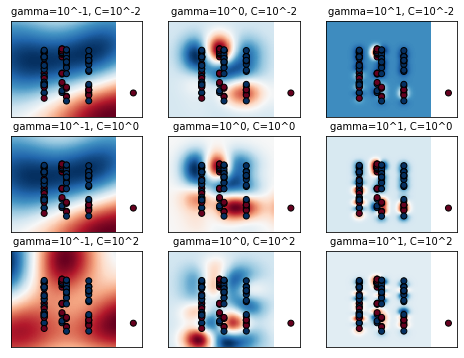

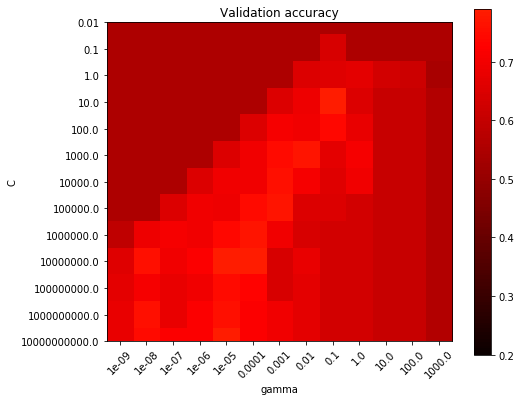

In [15]:
# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# #############################################################################
# Load and prepare data set
#
# dataset for grid search

### iris = load_iris()
### X = iris.data
### y = iris.target

X = df_data_pos.iloc[:,:-1].values
y = df_data_pos.iloc[:,-1].values

# Dataset for decision function visualization: we only keep the first two
# features in X and sub-sample the dataset to keep only 2 classes and
# make it a binary classification problem.

X_2d = X[:, 7:9]
#X_2d = X_2d[y > 0]
#y_2d = y[y > 0]
#y_2d -= 1
y_2d = y

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

# #############################################################################
# Train classifiers
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

# #############################################################################
# Visualization
#
# draw visualization of parameter effects

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
plt.xlabel('gamma')
plt.ylabel('C')
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('Validation accuracy')
plt.show()

The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.83


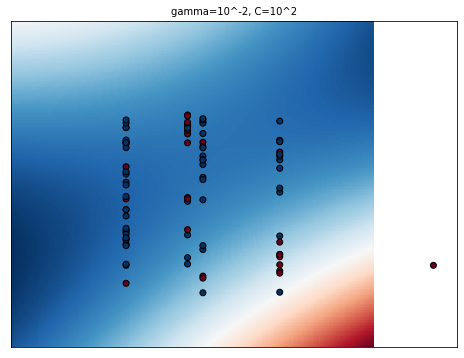

In [16]:
# Utility function to move the midpoint of a colormap to be around
# the values of interest.

class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# #############################################################################
# Load and prepare data set
#
# dataset for grid search

### iris = load_iris()
### X = iris.data
### y = iris.target

X = df_data_neg.iloc[:,:-1].values
y = df_data_neg.iloc[:,-1].values

# Dataset for decision function visualization: we only keep the first two
# features in X and sub-sample the dataset to keep only 2 classes and
# make it a binary classification problem.

X_2d = X[:, 7:9]
#X_2d = X_2d[y > 0]
#y_2d = y[y > 0]
#y_2d -= 1
y_2d = y

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

# #############################################################################
# Train classifiers
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

C_2d_range = [100]
gamma_2d_range = [1e-2]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

# #############################################################################
# Visualization
#
# draw visualization of parameter effects

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

#plt.figure(figsize=(8, 6))
#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
#plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
#           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
#plt.xlabel('gamma')
#plt.ylabel('C')
#plt.colorbar()
#plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
#plt.yticks(np.arange(len(C_range)), C_range)
#plt.title('Validation accuracy')
#plt.show()

The best parameters are {'C': 10.0, 'gamma': 0.1} with a score of 0.79


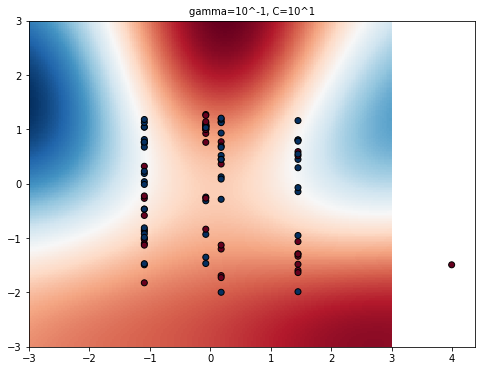

In [18]:
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

# #############################################################################
# Load and prepare data set
#
# dataset for grid search

### iris = load_iris()
### X = iris.data
### y = iris.target

X = df_data_pos.iloc[:,:-1].values
y = df_data_pos.iloc[:,-1].values

# Dataset for decision function visualization: we only keep the first two
# features in X and sub-sample the dataset to keep only 2 classes and
# make it a binary classification problem.

X_2d = X[:, 7:9]
#X_2d = X_2d[y > 0]
#y_2d = y[y > 0]
#y_2d -= 1
y_2d = y

# It is usually a good idea to scale the data for SVM training.
# We are cheating a bit in this example in scaling all of the data,
# instead of fitting the transformation on the training set and
# just applying it on the test set.

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

# #############################################################################
# Train classifiers
#
# For an initial search, a logarithmic grid with basis
# 10 is often helpful. Using a basis of 2, a finer
# tuning can be achieved but at a much higher cost.

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

# Now we need to fit a classifier for all parameters in the 2d version
# (we use a smaller set of parameters here because it takes a while to train)

C_2d_range = [10]
gamma_2d_range = [1e-1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

# #############################################################################
# Visualization
#
# draw visualization of parameter effects

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)),
              size='medium')

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r,
                edgecolors='k')
    #plt.xticks(())
    #plt.yticks(())
    plt.axis('tight')

scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

# Draw heatmap of the validation accuracy as a function of gamma and C
#
# The score are encoded as colors with the hot colormap which varies from dark
# red to bright yellow. As the most interesting scores are all located in the
# 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
# as to make it easier to visualize the small variations of score values in the
# interesting range while not brutally collapsing all the low score values to
# the same color.

#plt.figure(figsize=(8, 6))
#plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
#plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
#           norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
#plt.xlabel('gamma')
#plt.ylabel('C')
#plt.colorbar()
#plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
#plt.yticks(np.arange(len(C_range)), C_range)
#plt.title('Validation accuracy')
#plt.show()